# Transformer

https://arxiv.org/pdf/2101.01169.pdf  


기존의 시퀀스 변환 모델은 encoder-decoder 구조의 복잡한 RNN or CNN 기반의 모델이였는데 가장 좋은 성능을 보이는 것은 어텐션 메커니즘을 이용한 모델이였음.  

RNN, LSTM, GRU 구조는 각각 좋은 성능을 보여줬지만 시퀀스를 생성할때 이전의 은닉 상태와 입력이 필요하여 병렬 처리가 불가능하다.  

따라서 encoder-decoder 구조로 어텐션만을 이용하여 뛰어난 성능을 보이는 구조 Transformer를 제안  
WMT 2014 English-to-German translation task에서 28.4 BLEU score  
WMT 2014 English-to-French translation task에서 41.8 BLEU score

## 구조

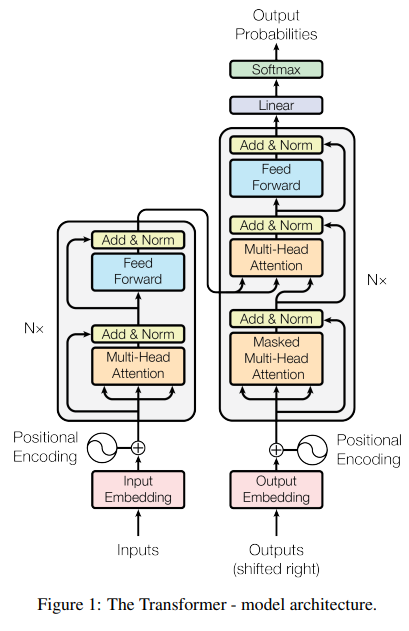

### Encoder :  
1. N개의 identical layers
2. multi-head self-attention, feed-forward network 두 개의 sub-layers로 이루어짐
3. residual connection, layer normalization 적용  

Encoder에서는 한번에 병렬적으로 어텐션값을 구할수 있음 (reccurent net 사용 x)  


### Decoder :   
1. Encoder의 구조와 비슷하며 sub-layer하나가 추가됨 (multi-head attention)  
2. Encoder output을 각각의 Decoder layer에 입력하여 최종 출력

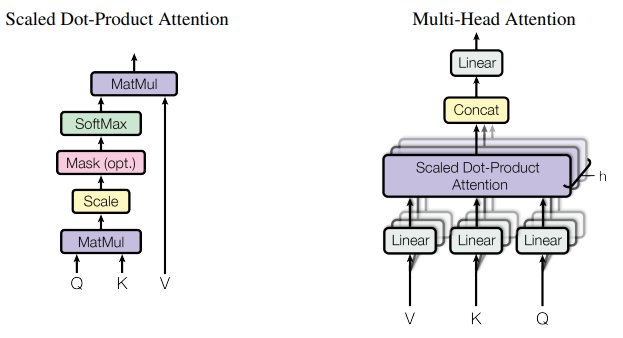

### Scaled Dot-product attention :   

기존 dot-product attention과 이론적 복잡도 유사하지만 더 빠르고 공간 효율적임, 또한 dot-product의 경우 $d_k$(Key의 차원)이 커질수록 gradient가 작아지는 문제를 해결하기위해 스케일링  


### Multi-head attention :   

single-head attention보다 $h$번 서로 다르게 학습된 mulit-head attention이 더 좋은 효과를 내는것을 알아냄.  
$d_{model}$(모델의 임베딩 차원)을 $h$로 나누어서  $d_k$, $d_v$ 등을 결정, 계산후에 이어 붙이면서 결과적으로 입력과 출력 차원이 같아지고  
전체 계산 비용은 single-head attention과 비슷함  

### Why self-attention :   

1. 레이어 당 총 계산복잡도 줄어듬
2. 병렬화 될 수 있는 계산량
3. long-range dependency에서도 잘 처리 할 수 있음

# 코드실습

## 라이브러리

In [ ]:
# https://arxiv.org/pdf/1706.03762.pdf
# https://tutorials.pytorch.kr/beginner/transformer_tutorial.html

import math
import copy
import time
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## model define

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
        
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)